# Content Based 3d Model Retrieval

### How are voxels counted? 
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

### plotting voxels in matplotlib

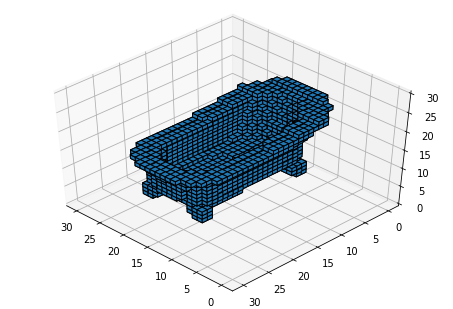

In [2]:
import matplotlib.pyplot as plt
from plots import plot_vox_file
%matplotlib inline


plot_vox_file('./ModelNet10/bathtub/train/bathtub_0005.binvox')

## Evaluate class balance for ModelNet10 and ModelNet40

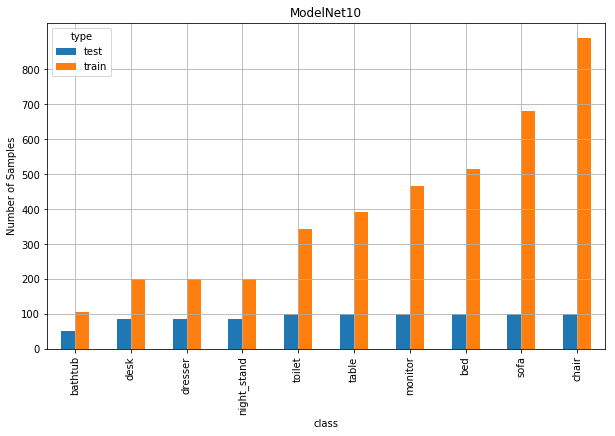

type,test,train
class,,
bathtub,50,106
desk,86,200
dresser,86,200
night_stand,86,200
toilet,100,344
table,100,392
monitor,100,465
bed,100,515
sofa,100,680


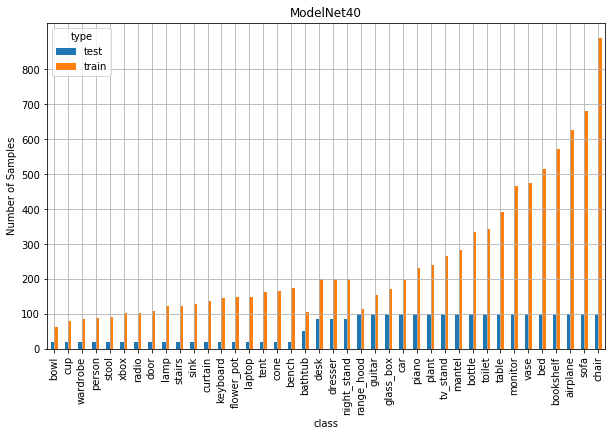

type,test,train
class,,
bowl,20,64
cup,20,79
wardrobe,20,87
person,20,88
stool,20,90
xbox,20,103
radio,20,104
door,20,109
lamp,20,124


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from count_files import (make_file_description_data_frame,
                         plot_unbalanced_classes)

df = make_file_description_data_frame('./ModelNet10/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet10')

df = make_file_description_data_frame('./ModelNet40/', show_missed=False)
plot_unbalanced_classes(df, 'ModelNet40')

## Get the Data

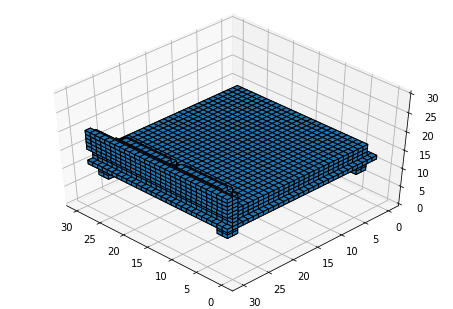

This is a bed.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from data import load_data
from plots import plot_vox

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')

plot_vox(x_train[0].reshape(30, 30, 30)), \
print("This is a {}.".format(target_names[y_train[0]]));

### Class Balance

class to class imbalance is dealt with using upsampling on **only the training data**

train to val imbalance is dealt with using stratified sampling

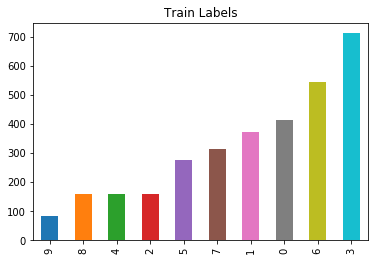

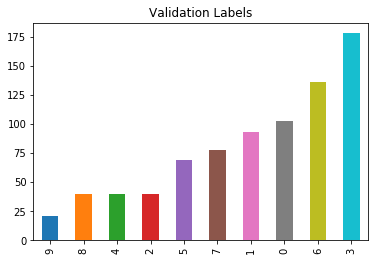

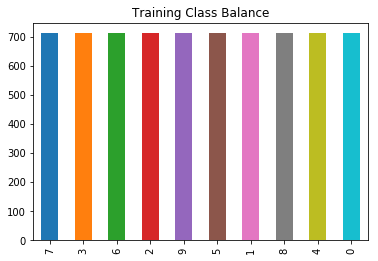

In [1]:
from plots import plot_class_balance
%matplotlib inline

plot_class_balance()

### Build Model
as found in ShapeNets3d paper

In [1]:
import pandas as pd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from data import load_data
from plots import plot_vox
from utils import upsample_classes, stratified_shuffle

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet10/')
x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
x_train, y_train = upsample_classes(x_train, y_train)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

/Users/ryan/repos/3d_model_retriever/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [119]:
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


model = Sequential()
model.add(Conv3D(10, (7, 7, 7), strides=7,
                 padding='same',
                 activation='relu',
                 input_shape=(30, 30, 30, 1)))
model.add(MaxPooling3D((2, 2, 2),
                        padding='same',
                        strides=1))
model.add(Conv3D(10, (2, 2, 2), strides=1,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling3D((2, 2, 2),
                       strides=1,
                       padding='same'))
model.add(GlobalAveragePooling3D())
# model.add(Flatten(input_shape=(20,)))
model.add(Dense(30, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='softmax'))

# ### TODO: Define your architecture.

model.summary()
model.compile('sgd', 'categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_122 (Conv3D)          (None, 5, 5, 5, 10)       3440      
_________________________________________________________________
max_pooling3d_102 (MaxPoolin (None, 5, 5, 5, 10)       0         
_________________________________________________________________
conv3d_123 (Conv3D)          (None, 5, 5, 5, 10)       810       
_________________________________________________________________
max_pooling3d_103 (MaxPoolin (None, 5, 5, 5, 10)       0         
_________________________________________________________________
global_average_pooling3d_25  (None, 10)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 30)                330       
_________________________________________________________________
dropout_31 (Dropout)         (None, 30)                0         
__________

In [120]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(x_train, y_train,
          epochs=10,
          batch_size=100,
          shuffle=True,
          validation_split=.25,
          callbacks=[TensorBoard(log_dir='./tensor_board.log'), checkpointer])

model.evaluate(x_test, y_test)

Train on 2992 samples, validate on 998 samples
Epoch 1/10
2992/2992 [==============================] - 873s 292ms/step - loss: 2.2918 - acc: 0.1484 - val_loss: 2.2863 - val_acc: 0.1533

Epoch 00001: val_loss improved from inf to 2.28627, saving model to weights.best.hdf5
Epoch 2/10
2992/2992 [==============================] - 877s 293ms/step - loss: 2.2747 - acc: 0.1942 - val_loss: 2.2732 - val_acc: 0.2224

Epoch 00002: val_loss improved from 2.28627 to 2.27319, saving model to weights.best.hdf5
Epoch 3/10


KeyboardInterrupt: 

In [121]:
model.evaluate(x_test, y_test)

908/908 [==============================] - 1s 1ms/step


[2.296310419553177, 0.13766519823788545]

# Appendix: